In [5]:
import pandas as pd
import seaborn as sns
import pickle
from sklearn import preprocessing
from datetime import datetime, date, timedelta

In [6]:
# Define function to select orders based on dates
## Either specifying a starting and endind date
## Either specifying and end date, and number of days before 

def period_selection(dt, end, start = None, n_days = None):
    to_return = dt.copy()
    if start is None and n_days is None:
        raise ValueError("Starting date, or duration (n_days) must be given")
    else:
        if start is None :
            start = end - timedelta(days = n_days) 
    
    print("Start : {}, end : {}".format(start, end))

    to_return = to_return[ (to_return.order_approved_at > start) & (to_return.order_approved_at < end) ]            
    return to_return            

# Define function to compute RFM + mean review score (rfm extended)
def rfm_ex(dt):
    
    min_date = min(dt.order_approved_at)
    max_date = max(dt.order_approved_at)
    period_length_days = (max_date - min_date).days
    
    # Get last order for each customer unique id
    recence = dt.loc[:,['customer_unique_id', 'order_approved_at'] ].\
                sort_values(by="order_approved_at").\
                drop_duplicates(subset=["customer_unique_id"], keep="last").\
                reset_index(drop=True)
    
    # Compute time since last order
    recence.loc[:,'order_approved_at'] = recence.loc[:,'order_approved_at'].apply(lambda x : (max_date - x).days )

    recence.rename(columns={"order_approved_at": "recence",}, inplace=True)
    
    # Get frequency
    frequence = dt.groupby('customer_unique_id').customer_unique_id.count() / period_length_days
    frequence = pd.DataFrame({ 'customer_unique_id' : frequence.index, 
                               'frequency' : frequence.values})
    
    # Montant (total ? mean ?)
    montant = dt.groupby('customer_unique_id').payment_value.sum() / period_length_days
    montant = pd.DataFrame({ 'customer_unique_id' : montant.index, 
                             'montant' : montant.values})
    
    # Review
    revs = dt.groupby('customer_unique_id').review_score.mean()
    revs = pd.DataFrame({ 'customer_unique_id' : revs.index, 
                          'review_score' : revs.values})
    
    rfm = recence.merge(frequence, on = 'customer_unique_id').\
                  merge(montant, on = 'customer_unique_id').\
                  merge(revs, on = 'customer_unique_id')
    return rfm

# Clustering - RFM

In [7]:
## Get data and scaling

full_dt = pd.read_csv('./data/clean_data.csv')
full_dt.order_approved_at = full_dt.order_approved_at.apply(lambda x : datetime.strptime(x, "%Y-%m-%d").date())

last_date = list(full_dt.order_approved_at.sort_values())[full_dt.shape[0]-1]
period = period_selection(full_dt, end = last_date, n_days = 700) # Use all data
dt = rfm_ex(period)

# Scaling (RFM)
X_subset = dt.loc[:,['recence','frequency', 'montant']]
X_subset_scaled = preprocessing.StandardScaler().fit_transform(X_subset)

# Scaling (RFMe)
X = dt.iloc[:,1:]
X = X[~X.review_score.isna()]
X_scaled = preprocessing.StandardScaler().fit_transform(X)

Start : 2016-09-28, end : 2018-08-29


In [8]:
from sklearn import cluster
from sklearn import metrics

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## k-means

In [9]:
model = cluster.KMeans(init="k-means++")

### Using distortion (or WCSS)
$wcss = \sum_{i}^{N} d(x_i, K(i))^2$, with $K(i)$ the centroid of group to which $x_i$ belong 

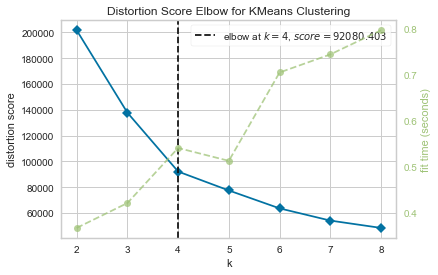

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
# distortion: mean sum of squared distances to centers
visualizer = KElbowVisualizer(model, k=(2,9))
visualizer.fit(X_subset_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

### Using Silhouette

Pour un point $i$ appartenant au group $k$ :

Distance moy. du point à son groupe $a(i) = \frac{1}{|I_k|-1}\sum_{j \in I_k, j \neq i} d(x^i, x^j)$

Distance moy. du point à ceux du groupe le plus proche $b(i) = min_{k'\neq k} \frac{1}{|I_{k'}|-1}\sum_{i' \in I_{k'}} d(x^i, x^{i'})$

Le coef. de silhouette pour $i$ est finalement : $s(i)=\frac{b(i)-a(i)}{max(a(i), b(i))}$

Et pour finir, sur l'ensemble des données: $S = \frac{1}{K}\sum_{k=1}^{K}\frac{1}{|I_k|}\sum_{i \in I_k} s(i)$


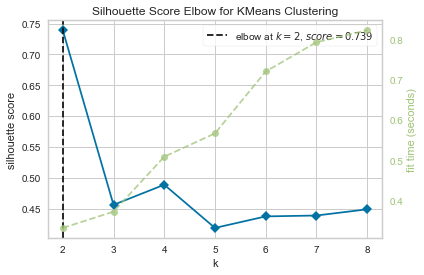

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [19]:
# silhouette: mean ratio of intra-cluster and nearest-cluster distance 
visualizer = KElbowVisualizer(model, k=(2,9), metric='silhouette')
visualizer.fit(X_subset_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Based on both, $k=3$ ou $k=4$ seems fine

In [10]:
from collections import Counter
import numpy as np

print("With 4 clusters")
model_rfm_k4 = cluster.KMeans(init="k-means++", n_clusters = 4).fit(X_subset_scaled)
print( np.array(list(Counter(model_rfm_k4.labels_).values())) / sum(np.array(list(Counter(model_rfm_k4.labels_).values()))) )

print("With 3 clusters")
model_rfm_k3 = cluster.KMeans(init="k-means++", n_clusters = 3).fit(X_subset_scaled)
print( np.array(list(Counter(model_rfm_k3.labels_).values())) / sum(np.array(list(Counter(model_rfm_k3.labels_).values()))) )

With 4 clusters
[0.40184933 0.02604708 0.0296686  0.54243499]
With 3 clusters
[0.41350677 0.03004361 0.55644963]


#### Cluster in t-SNE (3 clusters)

In [11]:
## Import t-SNE results
with open('./data/t-SNE_subset_25.pkl', 'rb') as inp:
    X_subset_tsne_25 = pickle.load(inp)
with open('./data/t-SNE_subset_50.pkl', 'rb') as inp:
    X_subset_tsne_50 = pickle.load(inp)
with open('./data/t-SNE_subset_100.pkl', 'rb') as inp:
    X_subset_tsne_100 = pickle.load(inp)
with open('./data/t-SNE_subset_200.pkl', 'rb') as inp:
    X_subset_tsne_200 = pickle.load(inp)
with open('./data/t-SNE_subset_300.pkl', 'rb') as inp:
    X_subset_tsne_300 = pickle.load(inp)

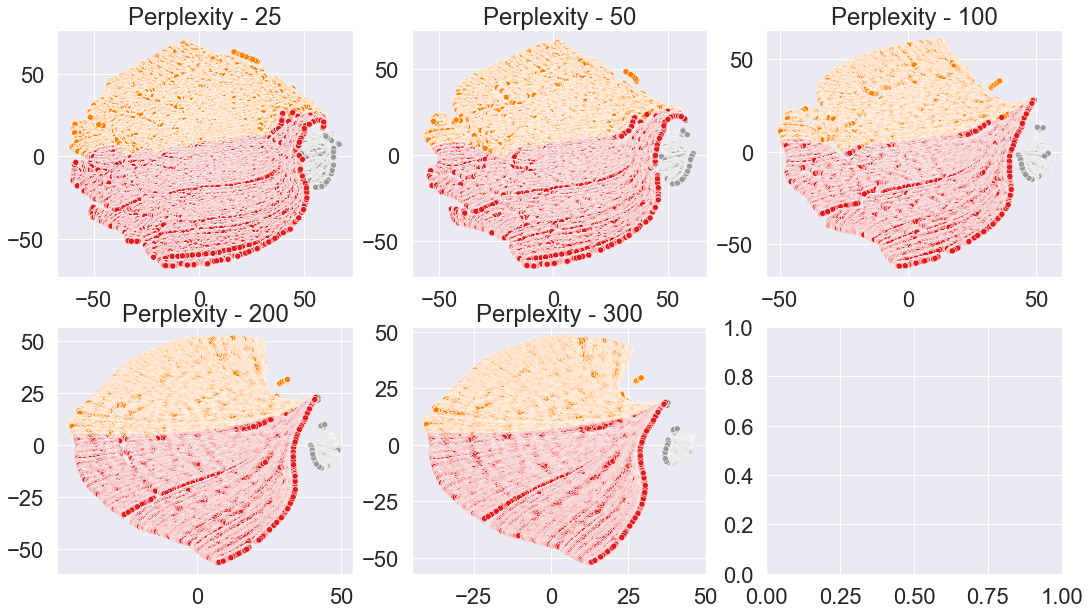

In [14]:
## Clusters in t-SNE
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize':(18,10)}, font_scale = 2)
fig,ax = plt.subplots(2,3)

sns.scatterplot(x = X_subset_tsne_25[:, 0], y = X_subset_tsne_25[:, 1], c = model_rfm_k3.labels_, cmap = "Set1", ax=ax[0,0]).set(title='Perplexity - 25');
sns.scatterplot(x = X_subset_tsne_50[:, 0], y = X_subset_tsne_50[:, 1], c = model_rfm_k3.labels_, cmap = "Set1", ax=ax[0,1]).set(title='Perplexity - 50');
sns.scatterplot(x = X_subset_tsne_100[:, 0], y = X_subset_tsne_100[:, 1], c = model_rfm_k3.labels_, cmap = "Set1", ax=ax[0,2]).set(title='Perplexity - 100');

sns.scatterplot(x = X_subset_tsne_200[:, 0], y = X_subset_tsne_200[:, 1], c = model_rfm_k3.labels_, cmap = "Set1", ax=ax[1,0]).set(title='Perplexity - 200');
sns.scatterplot(x = X_subset_tsne_300[:, 0], y = X_subset_tsne_300[:, 1], c = model_rfm_k3.labels_, cmap = "Set1", ax=ax[1,1]).set(title='Perplexity - 300');

#### Cluster in t-SNE (4 clusters)

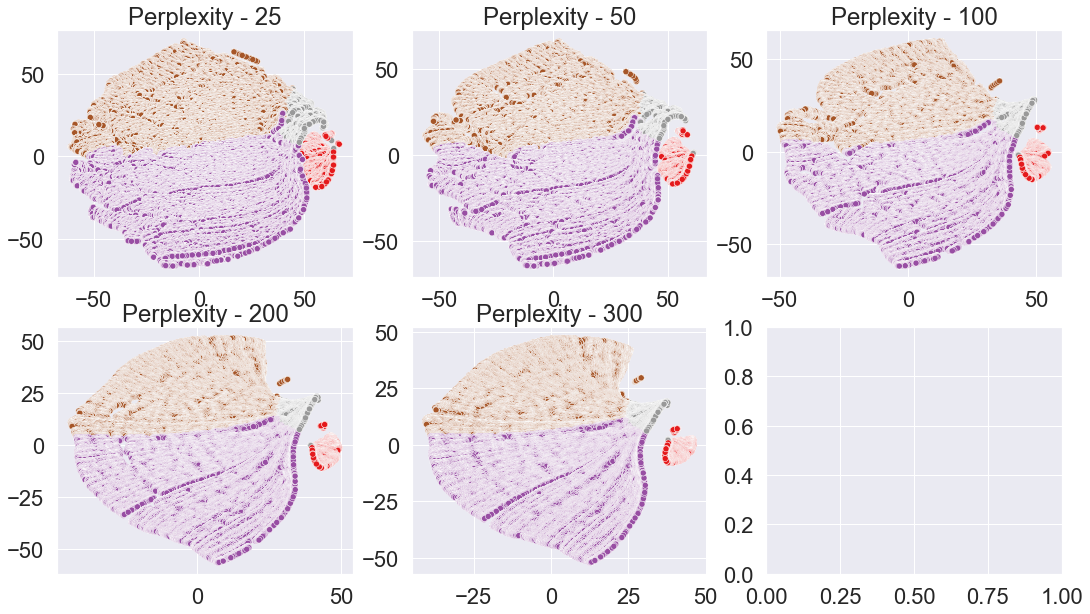

In [15]:
fig, ax = plt.subplots(2,3)

sns.scatterplot(x = X_subset_tsne_25[:, 0], y = X_subset_tsne_25[:, 1], c = model_rfm_k4.labels_, cmap = "Set1", ax=ax[0,0]).set(title='Perplexity - 25');
sns.scatterplot(x = X_subset_tsne_50[:, 0], y = X_subset_tsne_50[:, 1], c = model_rfm_k4.labels_, cmap = "Set1", ax=ax[0,1]).set(title='Perplexity - 50');
sns.scatterplot(x = X_subset_tsne_100[:, 0], y = X_subset_tsne_100[:, 1], c = model_rfm_k4.labels_, cmap = "Set1", ax=ax[0,2]).set(title='Perplexity - 100');

sns.scatterplot(x = X_subset_tsne_200[:, 0], y = X_subset_tsne_200[:, 1], c = model_rfm_k4.labels_, cmap = "Set1", ax=ax[1,0]).set(title='Perplexity - 200');
sns.scatterplot(x = X_subset_tsne_300[:, 0], y = X_subset_tsne_300[:, 1], c = model_rfm_k4.labels_, cmap = "Set1", ax=ax[1,1]).set(title='Perplexity - 300');


#### Clusters in 3D

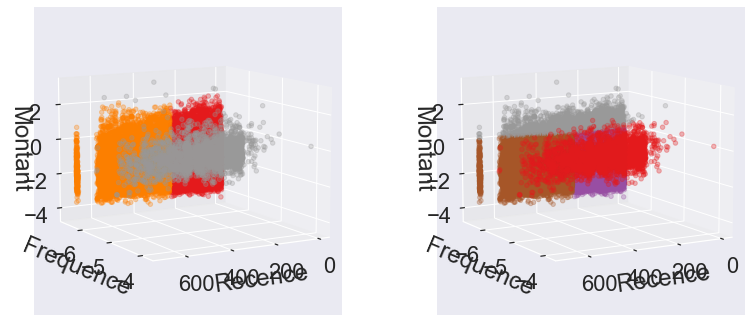

In [20]:
# Clusters in 3D
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.scatter3D(dt.recence, np.log(dt.frequency), np.log(dt.montant), c = model_rfm_k3.labels_ , cmap = "Set1", alpha = 0.3);
ax.set_ylabel('Frequence')
ax.set_xlabel('Recence')
ax.set_zlabel('Montant')
ax.view_init(elev=10, azim=60)


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(dt.recence, np.log(dt.frequency), np.log(dt.montant), c = model_rfm_k4.labels_ , cmap = "Set1", alpha = 0.3);
ax.set_ylabel('Frequence')
ax.set_xlabel('Recence')
ax.set_zlabel('Montant')
ax.view_init(elev=10, azim=60)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


With 3 clusters : clients are segmented as : (i) clients with multiple orders (ca. 3%), (ii) clients with one recent order, (iii) clients with one older order.

With 4 clusters, the additional cluster represents client with one order, whatever the recence but with high 'montant'.

#### Detailled repartition

<AxesSubplot:ylabel='montant'>

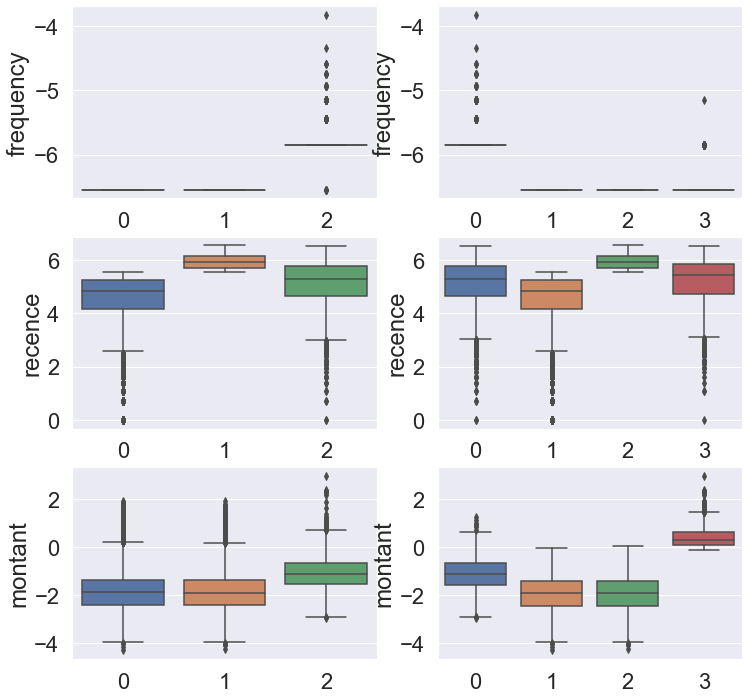

In [21]:
#### Detailled repartition
sns.set(rc = {'figure.figsize':(12,12)}, font_scale = 2)
fig, ax = plt.subplots(3,2)

sns.boxplot(y = np.log(X_subset['frequency']), x = model_rfm_k3.labels_, ax = ax[0,0])
sns.boxplot(y = np.log(X_subset['frequency']), x = model_rfm_k4.labels_, ax = ax[0,1])

sns.boxplot(y = np.log(X_subset['recence']+1), x = model_rfm_k3.labels_, ax = ax[1,0])
sns.boxplot(y = np.log(X_subset['recence']+1), x = model_rfm_k4.labels_, ax = ax[1,1])

sns.boxplot(y = np.log(X_subset['montant']), x = model_rfm_k3.labels_, ax = ax[2,0])
sns.boxplot(y = np.log(X_subset['montant']), x = model_rfm_k4.labels_, ax = ax[2,1])

In [22]:
# Mean by cluster
print(X_subset.groupby(model_rfm_k3.labels_).mean())
print(X_subset.groupby(model_rfm_k3.labels_).count())
# mean by cluster
print(X_subset.groupby(model_rfm_k4.labels_).mean())
print(X_subset.groupby(model_rfm_k4.labels_).count())

      recence  frequency   montant
0  126.013922   0.001443  0.230645
1  385.152644   0.001443  0.232042
2  218.599144   0.003047  0.468964
   recence  frequency  montant
0    51934      51934    51934
1    38593      38593    38593
2     2804       2804     2804
      recence  frequency   montant
0  218.618274   0.003051  0.418108
1  126.133548   0.001443  0.193868
2  385.376296   0.001443  0.192320
3  237.361580   0.001461  1.671345
   recence  frequency  montant
0     2769       2769     2769
1    50626      50626    50626
2    37505      37505    37505
3     2431       2431     2431


#### Stability test

In [23]:
#### Stability test
n_repeat = 20

n_k = 3
stab_k3 = []

for k in range(n_repeat):
    model = cluster.KMeans(init='k-means++', n_clusters = n_k)
    model.fit(pd.DataFrame(X_subset_scaled).sample(frac=0.2))
    y_1 = model.predict(X_subset_scaled)

    model = cluster.KMeans(init='k-means++', n_clusters = n_k)
    model.fit(pd.DataFrame(X_subset_scaled).sample(frac=0.3))
    y_2 = model.predict(X_subset_scaled)

    stab_k3.append(100*metrics.adjusted_rand_score(y_1, y_2))
    
print(u"Stability with k = 3 : {:.2f} \u00B1 {:.2f} %".format(np.mean(stab_k3), np.sqrt(np.var(stab_k3))))

n_k = 4
stab_k4 = []

for k in range(n_repeat):
    model = cluster.KMeans(init='k-means++', n_clusters = n_k)
    model.fit(pd.DataFrame(X_subset_scaled).sample(frac=0.2))
    y_1 = model.predict(X_subset_scaled)

    model = cluster.KMeans(init='k-means++', n_clusters = n_k)
    model.fit(pd.DataFrame(X_subset_scaled).sample(frac=0.3))
    y_2 = model.predict(X_subset_scaled)

    stab_k4.append(100*metrics.adjusted_rand_score(y_1, y_2))

print(u"Stability with k = 4 : {:.2f} \u00B1 {:.2f} %".format(np.mean(stab_k4), np.sqrt(np.var(stab_k4))))


Stability with k = 3 : 98.97 ± 0.68 %
Stability with k = 4 : 97.95 ± 1.32 %


### Hierarchical clustering

In [25]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [34]:
# Subsetting 
import random 
smpl = random.sample(range(X_subset_scaled.shape[0]), int(0.5 * X_subset_scaled.shape[0]) )

X_subset_ = X_subset_scaled[smpl,:]
clustering_k3 = cluster.AgglomerativeClustering(n_clusters = 3, linkage = 'ward', compute_distances = True).fit(X_subset_)
clustering_k4 = cluster.AgglomerativeClustering(n_clusters = 4, linkage = 'ward', compute_distances = True).fit(X_subset_)

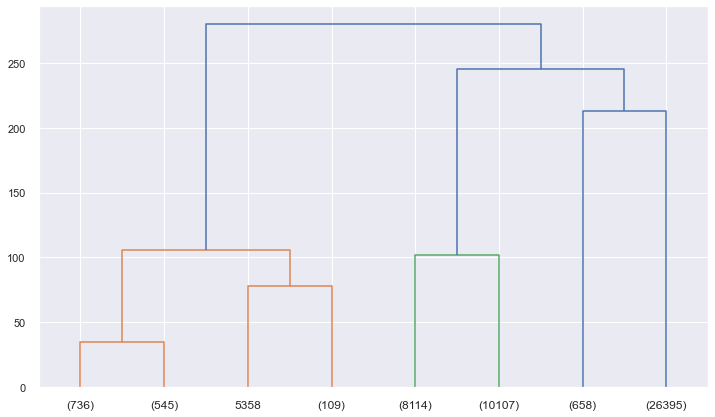

In [35]:
sns.set(rc = {'figure.figsize':(12,7)}, font_scale = 1)
plot_dendrogram(clustering_k4, truncate_mode="level", p=2)

#### Compare to k-means

In [36]:
## Compare to k-mean : 
print("Adjusted Rand Score (k3) : {:.2f}".format(metrics.adjusted_rand_score(model_rfm_k3.predict(X_subset_), clustering_k3.labels_)))
print("Adjusted Rand Score (k4) : {:.2f}".format(metrics.adjusted_rand_score(model_rfm_k4.predict(X_subset_), clustering_k4.labels_)))

Adjusted Rand Score (k3) : 0.82
Adjusted Rand Score (k4) : 0.84


#### Clusters in t-SNE (compare to k-means)

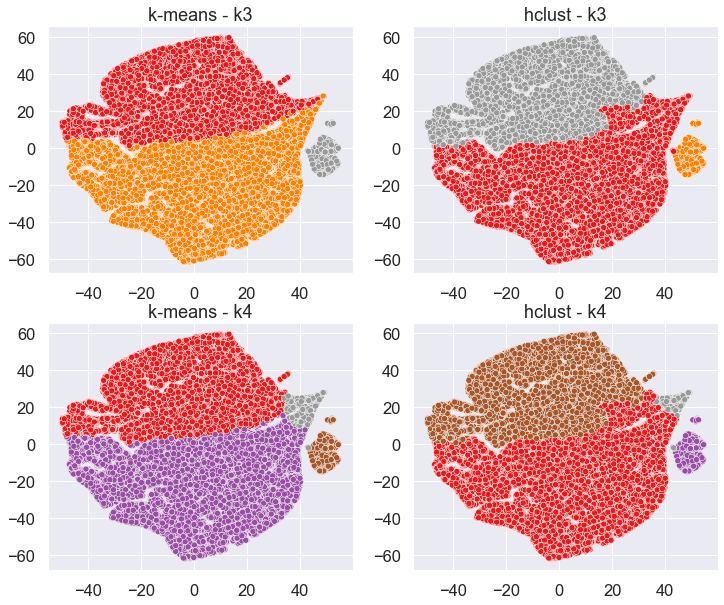

In [37]:
#### Clusters in t-SNE (compare to k-means)
sns.set(rc = {'figure.figsize':(12,10)}, font_scale = 1.5)
fig,ax = plt.subplots(2,2)

sns.scatterplot(x = X_subset_tsne_100[smpl, 0], y = X_subset_tsne_100[smpl, 1], c = model_rfm_k3.predict(X_subset_), cmap = "Set1", ax=ax[0,0]).set(title='k-means - k3');
sns.scatterplot(x = X_subset_tsne_100[smpl, 0], y = X_subset_tsne_100[smpl, 1], c = clustering_k3.labels_, cmap = "Set1", ax=ax[0,1]).set(title='hclust - k3');

sns.scatterplot(x = X_subset_tsne_100[smpl, 0], y = X_subset_tsne_100[smpl, 1], c = model_rfm_k4.predict(X_subset_), cmap = "Set1", ax=ax[1,0]).set(title='k-means - k4');
sns.scatterplot(x = X_subset_tsne_100[smpl, 0], y = X_subset_tsne_100[smpl, 1], c = clustering_k4.labels_, cmap = "Set1", ax=ax[1,1]).set(title='hclust - k4');

### DBScan 

#### Find good distance 
##### Heurictic #1

Following heuristic : 

+ $\epsilon$  : calculer pour chaque point de l'espace la distance à son plus proche voisin. Prendre $\epsilon$ tel qu'une part « suffisamment grande » des points aient une distance à son plus proche voisin inférieure à $\epsilon$ ;

+ MinPts : calculer pour chaque point le nombre de ses voisins dans un rayon de taille $\epsilon$ (la taille de son $\epsilon$-voisinage). Prendre MinPts tel qu'une part « suffisamment grande » des points aient plus de MinPts points dans leur $\epsilon$-voisinage.

C:\Users\max\AppData\Local\Temp/ipykernel_2332/681522219.py:12: RuntimeWarning: divide by zero encountered in log
  p=sns.scatterplot(x = np.array(range(len(distances_)))/len(distances_), y = np.log(distances_), ax = ax[0])


epsilon = 0.020959763994308517
MinPts = 1


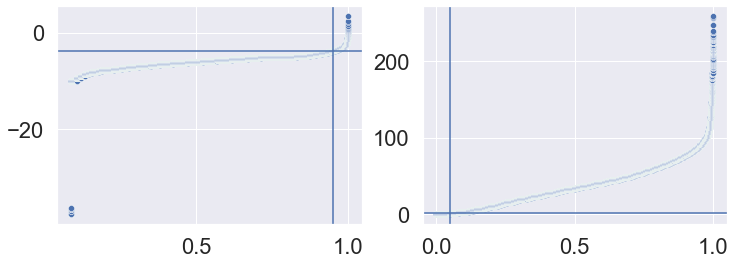

In [ ]:
from sklearn.neighbors import NearestNeighbors

sns.set(rc = {'figure.figsize':(12,4)}, font_scale = 2)
fig, ax = plt.subplots(1,2)

threshold = 0.95

# For epsilon
neigh = NearestNeighbors(n_neighbors=1).fit(X_subset_scaled).kneighbors()
distances_ = np.sort(neigh[0].reshape(-1))
epsilon = distances_[int(len(distances_) * threshold)]
p=sns.scatterplot(x = np.array(range(len(distances_)))/len(distances_), y = np.log(distances_), ax = ax[0])
p.axhline(np.log(epsilon))
p.axvline(threshold)

print("epsilon = {}".format(epsilon))

# For minPts
neigh = NearestNeighbors(radius = epsilon).fit(X_subset_scaled).radius_neighbors()
l_v = np.vectorize(len)
n_neighbors_ = np.sort(l_v(neigh[0].reshape(-1)))
minpts = n_neighbors_[int(len(n_neighbors_) * (1-threshold))]

p=sns.scatterplot(x = np.array(range(len(n_neighbors_)))/len(n_neighbors_), y = (n_neighbors_), ax = ax[1])
p.axhline(minpts)
p.axvline(1-threshold)

print("MinPts = {}".format(minpts))

##### DBScan #1

In [ ]:
dbscan = cluster.DBSCAN(eps = epsilon, min_samples = 1+minpts).fit(X_subset_scaled) # Min Samples included the point itself (that's why we add 1)
len(Counter(dbscan.labels_))

1693

Far to many clusters...

##### Heurictic #2

Une autre heuristique pour les cas en 2D (définie dans l'article original de DBSCAN1) consiste à fixer la valeur de MinPts à 4, et à tracer la courbe (triée dans l'ordre décroissant) des distances de chaque point à leur 4ème plus proche voisin. On fixe alors $\epsilon$ à la valeur du "point seuil" repéré sur le graphe. Si ce seuil n'est pas clairement identifiable, l'utilisateur peut le fixer en estimant le pourcentage de bruit dans le jeu de données : $\epsilon$ est donc tel que seuls les termes de bruit ont une distance à leur 4ème plus proche voisin plus grande que $\epsilon$. 

<AxesSubplot:>

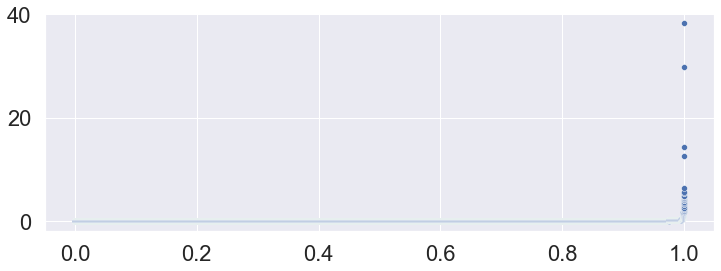

In [ ]:
neigh = NearestNeighbors(n_neighbors=4).fit(X_subset_scaled).kneighbors()
distances_ = np.sort(np.apply_along_axis(lambda x : max(x), 1, neigh[0]))
sns.scatterplot(x=np.array(range(len(distances_)))/len(distances_), y=distances_)

Not clear... Densities are probably not homogeneous in our dataset ! See 3D plot !

## Clustering - RFM extended

#### t-SNE

In [26]:
## Import t-SNE results
with open('./data/t-SNE_25.pkl', 'rb') as inp:
    X_tsne_25 = pickle.load(inp)
with open('./data/t-SNE_50.pkl', 'rb') as inp:
    X_tsne_50 = pickle.load(inp)
with open('./data/t-SNE_100.pkl', 'rb') as inp:
    X_tsne_100 = pickle.load(inp)
with open('./data/t-SNE_200.pkl', 'rb') as inp:
    X_tsne_200 = pickle.load(inp)
with open('./data/t-SNE_300.pkl', 'rb') as inp:
    X_tsne_300 = pickle.load(inp)

### k-means

#### Using distortion

In [27]:
model = cluster.KMeans(init="k-means++")

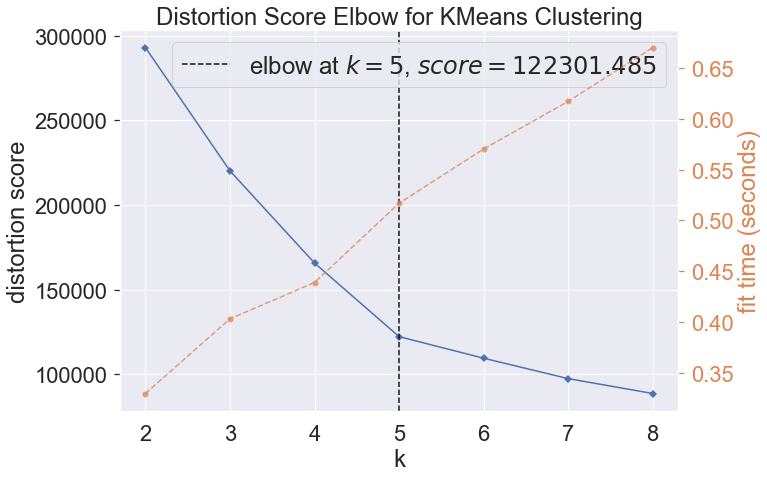

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
sns.set(rc = {'figure.figsize':(10,7)}, font_scale = 2)

# distortion: mean sum of squared distances to centers
visualizer = KElbowVisualizer(model, k=(2,9))
visualizer.fit(X_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [29]:
print("With 5 clusters")
model_rfme_k5 = cluster.KMeans(init="k-means++", n_clusters = 5).fit(X_scaled)
print( np.array(list(Counter(model_rfme_k5.labels_).values())) / sum(np.array(list(Counter(model_rfme_k5.labels_).values()))) )

print("With 4 clusters")
model_rfme_k4 = cluster.KMeans(init="k-means++", n_clusters = 4).fit(X_scaled)
print( np.array(list(Counter(model_rfme_k4.labels_).values())) / sum(np.array(list(Counter(model_rfme_k4.labels_).values()))) )


With 5 clusters
[0.33681304 0.16860064 0.02232335 0.02976447 0.44249849]
With 4 clusters
[0.34544043 0.17178199 0.03013114 0.45264645]


#### Cluster in t-SNE (4 clusters)

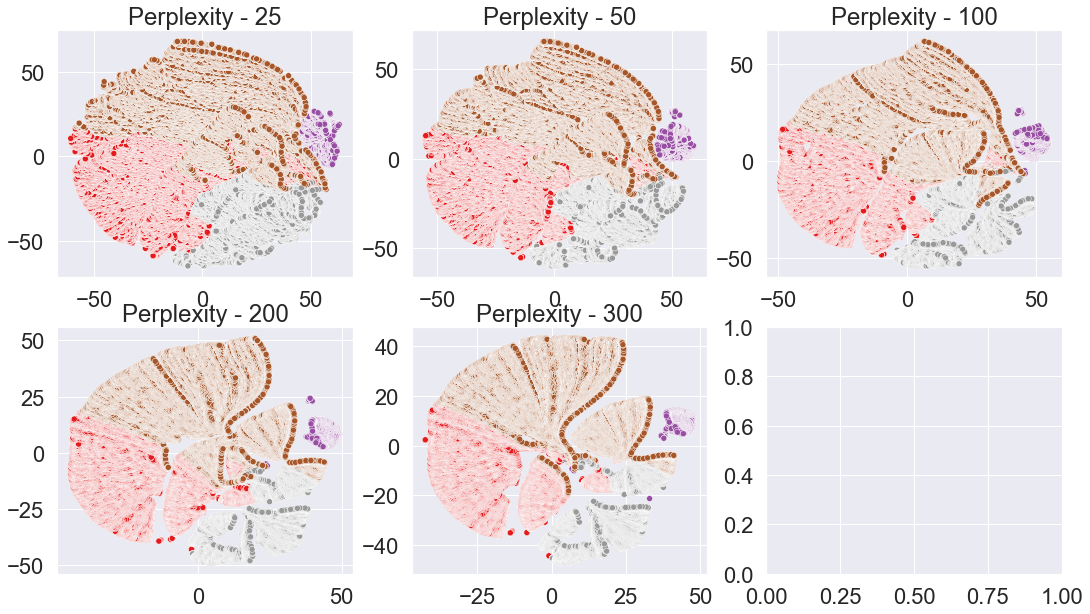

In [30]:
# Clusters in t-SNE

sns.set(rc = {'figure.figsize':(18,10)}, font_scale = 2)
fig,ax = plt.subplots(2,3)

sns.scatterplot(x = X_tsne_25[:, 0], y = X_tsne_25[:, 1], c = model_rfme_k4.labels_, cmap = "Set1", ax=ax[0,0]).set(title='Perplexity - 25');
sns.scatterplot(x = X_tsne_50[:, 0], y = X_tsne_50[:, 1], c = model_rfme_k4.labels_, cmap = "Set1", ax=ax[0,1]).set(title='Perplexity - 50');
sns.scatterplot(x = X_tsne_100[:, 0], y = X_tsne_100[:, 1], c = model_rfme_k4.labels_, cmap = "Set1", ax=ax[0,2]).set(title='Perplexity - 100');

sns.scatterplot(x = X_tsne_200[:, 0], y = X_tsne_200[:, 1], c = model_rfme_k4.labels_, cmap = "Set1", ax=ax[1,0]).set(title='Perplexity - 200');
sns.scatterplot(x = X_tsne_300[:, 0], y = X_tsne_300[:, 1], c = model_rfme_k4.labels_, cmap = "Set1", ax=ax[1,1]).set(title='Perplexity - 300');

#### Cluster in t-SNE (5 clusters)

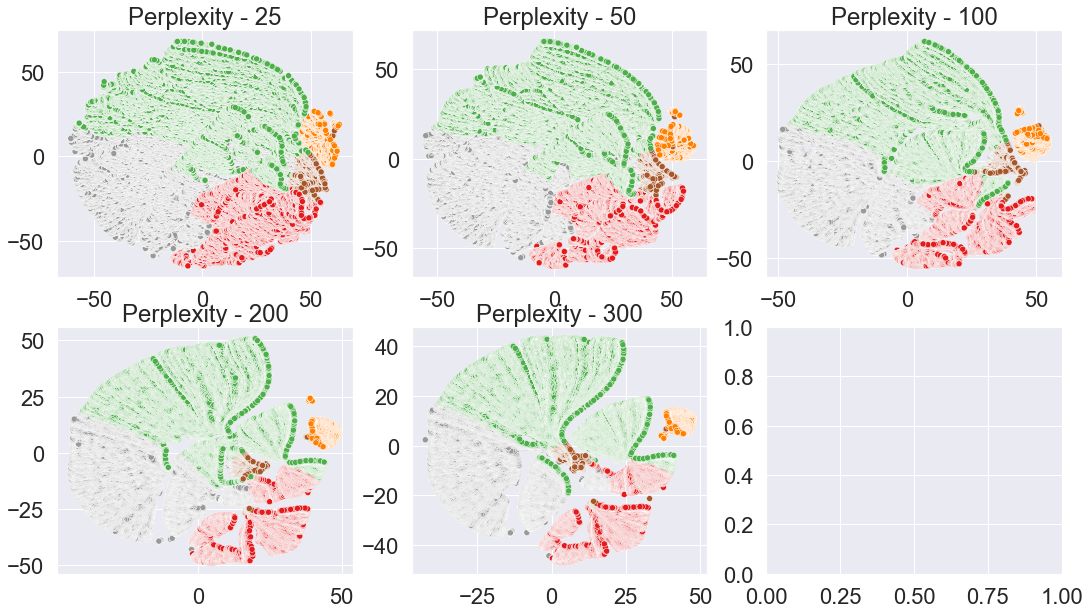

In [31]:
# Clusters in t-SNE

sns.set(rc = {'figure.figsize':(18,10)}, font_scale = 2)
fig,ax = plt.subplots(2,3)

sns.scatterplot(x = X_tsne_25[:, 0], y = X_tsne_25[:, 1], c = model_rfme_k5.labels_, cmap = "Set1", ax=ax[0,0]).set(title='Perplexity - 25');
sns.scatterplot(x = X_tsne_50[:, 0], y = X_tsne_50[:, 1], c = model_rfme_k5.labels_, cmap = "Set1", ax=ax[0,1]).set(title='Perplexity - 50');
sns.scatterplot(x = X_tsne_100[:, 0], y = X_tsne_100[:, 1], c = model_rfme_k5.labels_, cmap = "Set1", ax=ax[0,2]).set(title='Perplexity - 100');

sns.scatterplot(x = X_tsne_200[:, 0], y = X_tsne_200[:, 1], c = model_rfme_k5.labels_, cmap = "Set1", ax=ax[1,0]).set(title='Perplexity - 200');
sns.scatterplot(x = X_tsne_300[:, 0], y = X_tsne_300[:, 1], c = model_rfme_k5.labels_, cmap = "Set1", ax=ax[1,1]).set(title='Perplexity - 300');

#### Clusters in 3D

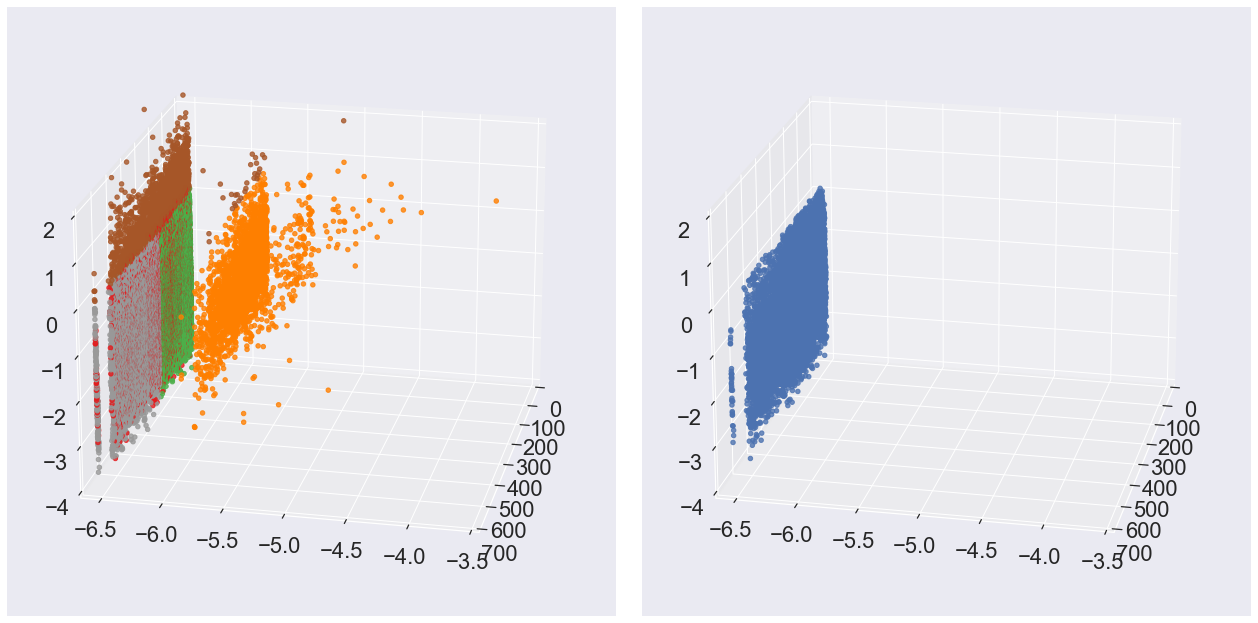

In [34]:
dt_ = dt[~dt.review_score.isna()]

# Clusters in 3D
fig = plt.figure(figsize=(18,20))
sns.set(font_scale = 2)

ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.scatter3D(dt_.recence, np.log(dt_.frequency), np.log(dt_.montant), c = model_rfme_k5.labels_ , cmap = "Set1", alpha = 0.8);
# ax.set_ylabel('Frequence')
# ax.set_xlabel('Recence')
# ax.set_zlabel('Montant')
ax.set_ylim(-6.6, -3.5)
ax.set_xlim(0, 700)
ax.set_zlim(-4,2)
ax.view_init(elev=20, azim=12)

ax = fig.add_subplot(1, 2, 2, projection='3d')

cat_2 = model_rfme_k5.labels_ == 0
ax.scatter3D(dt_.recence[cat_2], np.log(dt_.frequency[cat_2]), np.log(dt_.montant[cat_2]), cmap = "Set1", alpha = 0.8);
# ax.set_ylabel('Frequence')
# ax.set_xlabel('Recence')
# ax.set_zlabel('Montant')
ax.set_ylim(-6.6, -3.5)
ax.set_xlim(0, 700)
ax.set_zlim(-4,2)
ax.view_init(elev=20, azim=12)


# ax.scatter3D(dt_.recence, np.log(dt_.frequency), np.log(dt_.montant), c = model_rfme_k5.labels_[rs] , cmap = "Set1", alpha = model_rfme_k5.labels_[rs]);
# ax.set_ylabel('Frequence')
# ax.set_xlabel('Recence')
# ax.set_zlabel('Montant')
# ax.view_init(elev=20, azim=12)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


#### Detailled repartition

(0.0, 5.0)

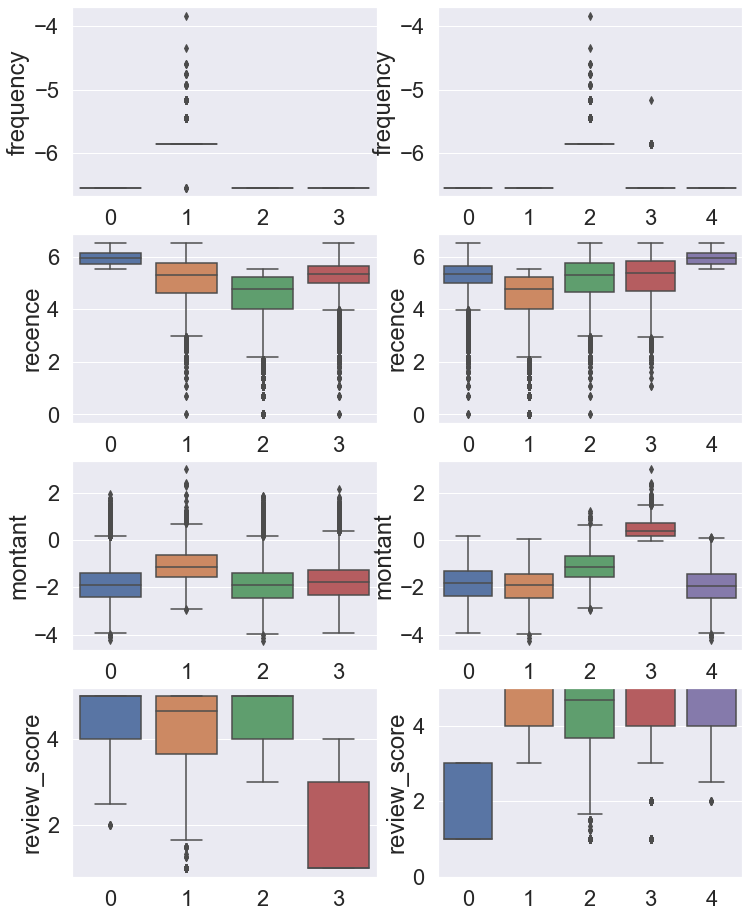

In [35]:

sns.set(rc = {'figure.figsize':(12,16)}, font_scale = 2)
fig, ax = plt.subplots(4,2)

sns.boxplot(y = np.log(X['frequency']), x = model_rfme_k4.labels_, ax = ax[0,0])
sns.boxplot(y = np.log(X['frequency']), x = model_rfme_k5.labels_, ax = ax[0,1])

sns.boxplot(y = np.log(X['recence']+1), x = model_rfme_k4.labels_, ax = ax[1,0])
sns.boxplot(y = np.log(X['recence']+1), x = model_rfme_k5.labels_, ax = ax[1,1])

sns.boxplot(y = np.log(X['montant']), x = model_rfme_k4.labels_, ax = ax[2,0])
sns.boxplot(y = np.log(X['montant']), x = model_rfme_k5.labels_, ax = ax[2,1])

sns.boxplot(y = (X['review_score']), x = model_rfme_k4.labels_, ax = ax[3,0])
sns.boxplot(y = (X['review_score']), x = model_rfme_k5.labels_, ax = ax[3,1])
plt.ylim(0, 5)

In [145]:
# Mean by cluster
print(X.groupby(model_rfme_k4.labels_).mean())
print(X.groupby(model_rfme_k4.labels_).count())

# mean by cluster
print(X.groupby(model_rfme_k5.labels_).mean())
print(X.groupby(model_rfme_k5.labels_).count())


      recence  frequency   montant  review_score
0  391.471966   0.001443  0.226695      4.639595
1  218.321761   0.003048  0.464317      4.203513
2  120.750101   0.001443  0.221810      4.702487
3  228.902254   0.001443  0.263875      1.721765
   recence  frequency  montant  review_score
0    32032      32032    32032         32032
1     2794       2794     2794          2794
2    41973      41973    41973         41973
3    15929      15929    15929         15929
      recence  frequency   montant  review_score
0  228.835807   0.001443  0.216862      1.732186
1  120.968585   0.001443  0.191252      4.705388
2  218.344565   0.003052  0.417420      4.204571
3  235.215459   0.001465  1.775761      4.094928
4  391.691855   0.001443  0.192313      4.640433
   recence  frequency  montant  review_score
0    15634      15634    15634         15634
1    41032      41032    41032         41032
2     2760       2760     2760          2760
3     2070       2070     2070          2070
4    31232 

In [36]:
# Look at transitions

set_1 = set(model_rfme_k4.labels_)
set_2 = set(model_rfme_k5.labels_)
t_ = np.zeros([ len(set_1), len(set_2) ]) 
for i in set_1:
    z = model_rfme_k5.labels_[ np.where(model_rfme_k4.labels_ == i) ]
    for j in set_2:
        t_[i, j] = np.sum( z == j )
i = list(set_1)[0]
j = list(set_2)[0]

t_

# from scipy.spatial import distance_matrix
# distance_matrix(X.groupby(model_rfme_k4.labels_).mean(), X.groupby(model_rfme_k5.labels_).mean())

# distance_matrix(X.groupby(model_rfme_k5.labels_).mean(), X.groupby(model_rfme_k4.labels_).mean())

array([[4.6000e+01, 2.1000e+01, 0.0000e+00, 7.3400e+02, 3.1231e+04],
       [0.0000e+00, 0.0000e+00, 2.7600e+03, 3.4000e+01, 0.0000e+00],
       [1.0300e+02, 4.1002e+04, 0.0000e+00, 8.6800e+02, 0.0000e+00],
       [1.5485e+04, 9.0000e+00, 0.0000e+00, 4.3400e+02, 1.0000e+00]])

#### Stability test


In [37]:
#### Stability test
n_repeat = 20

n_k = 4
stab_k4 = []

for k in range(n_repeat):
    model = cluster.KMeans(init='k-means++', n_clusters = n_k)
    model.fit(pd.DataFrame(X_scaled).sample(frac=0.2))
    y_1 = model.predict(X_scaled)

    model = cluster.KMeans(init='k-means++', n_clusters = n_k)
    model.fit(pd.DataFrame(X_scaled).sample(frac=0.3))
    y_2 = model.predict(X_scaled)

    stab_k4.append(100*metrics.adjusted_rand_score(y_1, y_2))
    
print(u"Stability with k = 4 : {:.2f} \u00B1 {:.2f} %".format(np.mean(stab_k4), np.sqrt(np.var(stab_k4))))

n_k = 5
stab_k5 = []

for k in range(n_repeat):
    model = cluster.KMeans(init='k-means++', n_clusters = n_k)
    model.fit(pd.DataFrame(X_scaled).sample(frac=0.2))
    y_1 = model.predict(X_scaled)

    model = cluster.KMeans(init='k-means++', n_clusters = n_k)
    model.fit(pd.DataFrame(X_scaled).sample(frac=0.3))
    y_2 = model.predict(X_scaled)

    stab_k5.append(100*metrics.adjusted_rand_score(y_1, y_2))

print(u"Stability with k = 5 : {:.2f} \u00B1 {:.2f} %".format(np.mean(stab_k5), np.sqrt(np.var(stab_k5))))


Stability with k = 4 : 98.22 ± 0.96 %
Stability with k = 5 : 98.41 ± 0.89 %


### Hierachical clustering


In [79]:
import random 
repeat_ = 5
smpl_ = []
clustering_rfme_k4 = []
clustering_rfme_k5 = []

for i in range(repeat_):
    smpl_.append(random.sample(range(X_scaled.shape[0]), int(0.3 * X_scaled.shape[0]) ))

    clustering_rfme_k4.append(cluster.AgglomerativeClustering(n_clusters = 4, linkage = 'ward', compute_distances = True).fit(X_scaled[smpl_[i],:]))
    clustering_rfme_k5.append(cluster.AgglomerativeClustering(n_clusters = 5, linkage = 'ward', compute_distances = True).fit(X_scaled[smpl_[i],:]))


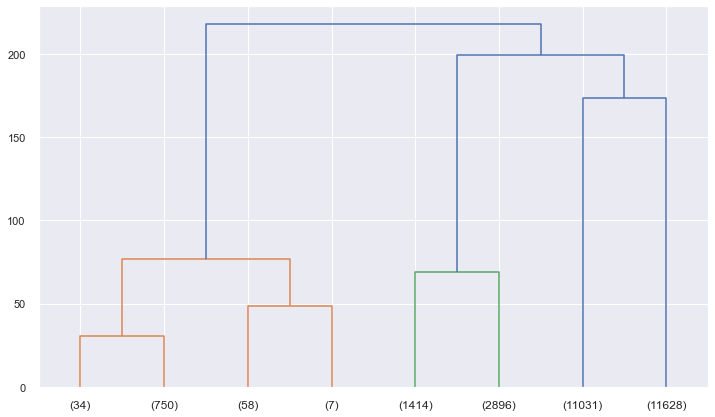

In [97]:
sns.set(rc = {'figure.figsize':(12,7)}, font_scale = 1)
plot_dendrogram(clustering_rfme_k5[4], truncate_mode="level", p=2)

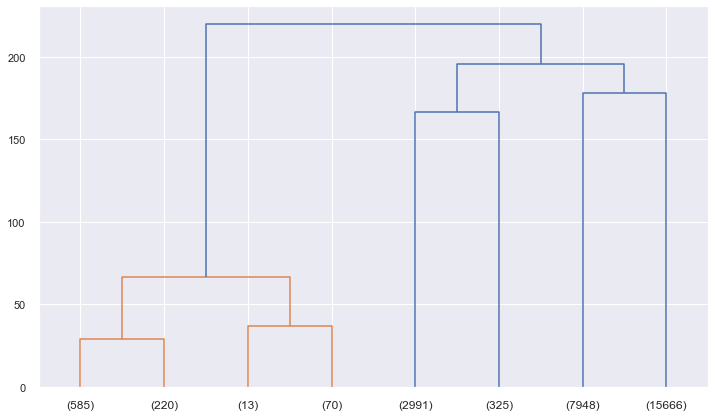

In [88]:
plot_dendrogram(clustering_rfme_k5[3], truncate_mode="level", p=2)

In [90]:
# Test method to assess stability (using kNN)
from sklearn.neighbors import KNeighborsClassifier
knns_5k = []
preds_5k = []
for i in range(repeat_):
    knns_5k.append(KNeighborsClassifier(n_neighbors=1))
    knns_5k[i].fit(X_scaled[smpl_[i],:], clustering_rfme_k5[i].labels_)
    preds_5k.append(knns_5k[i].predict(X_scaled))
    
aris_ = []
for i in range(repeat_-1):
    for j in range(i+1,repeat_):
        aris_.append(metrics.adjusted_rand_score(preds_5k[i], preds_5k[j]))
        
print("Stability (k:5, with 1-nn) : {:.2f} \u00B1 {:.2f} %".format(100*np.mean(aris_), 100*np.sqrt(np.var(aris_)))) 

Stability (k:5, with 1-nn) : 45.65 ± 15.49 %


In [91]:
# Test method to assess stability (using kNN)
from sklearn.neighbors import KNeighborsClassifier
knns_4k = []
preds_4k = []
for i in range(repeat_):
    knns_4k.append(KNeighborsClassifier(n_neighbors=1))
    knns_4k[i].fit(X_scaled[smpl_[i],:], clustering_rfme_k4[i].labels_)
    preds_4k.append(knns_4k[i].predict(X_scaled))
    
aris_ = []
for i in range(repeat_-1):
    for j in range(i+1,repeat_):
        aris_.append(metrics.adjusted_rand_score(preds_4k[i], preds_4k[j]))
        
print("Stability (k:4, with 1-nn) : {:.2f} \u00B1 {:.2f} %".format(100*np.mean(aris_), 100*np.sqrt(np.var(aris_)))) 

Stability (k:4, with 1-nn) : 41.01 ± 13.75 %


In [151]:
# mean by cluster
print(X.groupby(preds_5k[3]).mean())
print(X.groupby(preds_5k[3]).count())

# mean by cluster
print(X.groupby(preds_5k[0]).mean())
print(X.groupby(preds_5k[0]).count())


      recence  frequency   montant  review_score
0  148.890995   0.001443  0.210960      4.533754
1  218.025117   0.003051  0.439384      4.204383
2  266.116486   0.001446  2.312239      4.087858
3  412.272103   0.001443  0.186758      4.519070
4  230.437462   0.001443  0.250070      1.117578
   recence  frequency  montant  review_score
0    52750      52750    52750         52750
1     2787       2787     2787          2787
2     1013       1013     1013          1013
3    26376      26376    26376         26376
4     9802       9802     9802          9802
      recence  frequency   montant  review_score
0  331.224865   0.001443  0.167911      4.686059
1  222.989573   0.001444  1.444502      4.535991
2  237.998673   0.001443  0.235182      1.674796
3  218.025117   0.003051  0.439384      4.204383
4   82.497296   0.001443  0.202125      4.605681
   recence  frequency  montant  review_score
0    44529      44529    44529         44529
1     2973       2973     2973          2973
2    15

In [ ]:
#### Cluster in 3D

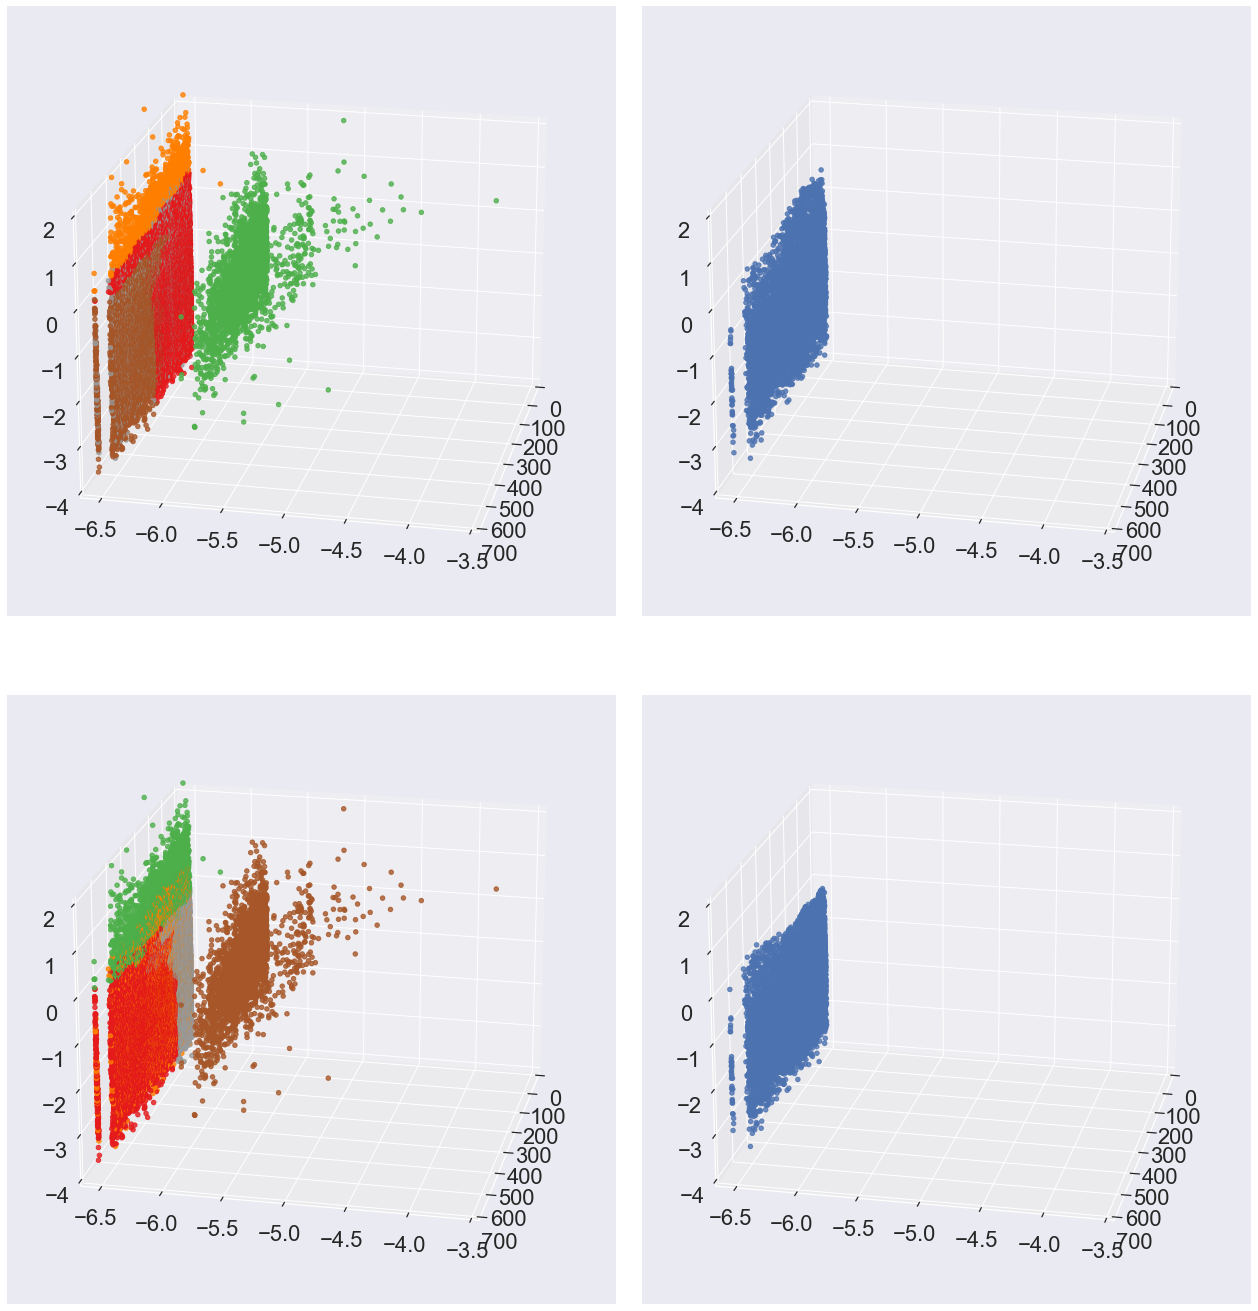

In [105]:
# Clusters in 3D
fig = plt.figure(figsize=(18,20))
sns.set(font_scale = 2)

ax = fig.add_subplot(2, 2, 1, projection='3d')

ax.scatter3D(X.recence, np.log(X.frequency), np.log(X.montant), c = preds_5k[3] , cmap = "Set1", alpha = 0.8);
# ax.set_ylabel('Frequence')
# ax.set_xlabel('Recence')
# ax.set_zlabel('Montant')
ax.set_ylim(-6.6, -3.5)
ax.set_xlim(0, 700)
ax.set_zlim(-4,2)
ax.view_init(elev=20, azim=12)

ax = fig.add_subplot(2, 2, 2, projection='3d')

cat_2 = preds_5k[3] == 4
ax.scatter3D(X.recence[cat_2], np.log(X.frequency[cat_2]), np.log(X.montant[cat_2]), cmap = "Set1", alpha = 0.8);
# ax.set_ylabel('Frequence')
# ax.set_xlabel('Recence')
# ax.set_zlabel('Montant')
ax.set_ylim(-6.6, -3.5)
ax.set_xlim(0, 700)
ax.set_zlim(-4,2)
ax.view_init(elev=20, azim=12)

ax = fig.add_subplot(2, 2, 3, projection='3d')

ax.scatter3D(X.recence, np.log(X.frequency), np.log(X.montant), c = preds_5k[0] , cmap = "Set1", alpha = 0.8);
# ax.set_ylabel('Frequence')
# ax.set_xlabel('Recence')
# ax.set_zlabel('Montant')
ax.set_ylim(-6.6, -3.5)
ax.set_xlim(0, 700)
ax.set_zlim(-4,2)
ax.view_init(elev=20, azim=12)

ax = fig.add_subplot(2, 2, 4, projection='3d')

cat_2 = preds_5k[4] == 2
ax.scatter3D(X.recence[cat_2], np.log(X.frequency[cat_2]), np.log(X.montant[cat_2]), cmap = "Set1", alpha = 0.8);
# ax.set_ylabel('Frequence')
# ax.set_xlabel('Recence')
# ax.set_zlabel('Montant')
ax.set_ylim(-6.6, -3.5)
ax.set_xlim(0, 700)
ax.set_zlim(-4,2)
ax.view_init(elev=20, azim=12)



fig.tight_layout()  # otherwise the right y-label is slightly clipped

#### Compared to k-means

In [93]:
## Compare to k-mean : 

aris_4k = []
aris_5k = []

for i in range(repeat_):
    aris_4k.append(metrics.adjusted_rand_score(model_rfme_k4.predict(X_scaled), preds_4k[i]))
    aris_5k.append(metrics.adjusted_rand_score(model_rfme_k5.predict(X_scaled), preds_5k[i]))


print("Adjusted Rand Score (k4) : {:.2f} \u00B1 {:.2f} %".format(100*np.mean(aris_4k), 100*np.sqrt(np.var(aris_4k)))) 
print("Adjusted Rand Score (k5) : {:.2f} \u00B1 {:.2f} %".format(100*np.mean(aris_5k), 100*np.sqrt(np.var(aris_5k))))

Adjusted Rand Score (k4) : 52.38 ± 13.61 %
Adjusted Rand Score (k5) : 55.89 ± 9.92 %


In [106]:
# Look at transitions

set_1 = set(model_rfme_k5.predict(X_scaled))
set_2 = set(preds_5k[3])
t_ = np.zeros([ len(set_1), len(set_2) ]) 
for i in set_1:
    z = preds_5k[3][ np.where(model_rfme_k5.predict(X_scaled) == i) ]
    for j in set_2:
        t_[i, j] = np.sum( z == j )
i = list(set_1)[0]
j = list(set_2)[0]

t_

array([[5.2340e+03, 0.0000e+00, 0.0000e+00, 7.6600e+02, 9.6340e+03],
       [4.0692e+04, 0.0000e+00, 0.0000e+00, 3.4000e+02, 0.0000e+00],
       [0.0000e+00, 2.7600e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [8.6700e+02, 2.7000e+01, 1.0130e+03, 1.0000e+00, 1.6200e+02],
       [5.9570e+03, 0.0000e+00, 0.0000e+00, 2.5269e+04, 6.0000e+00]])

#### Clusters in t-SNE (compare to k-means)

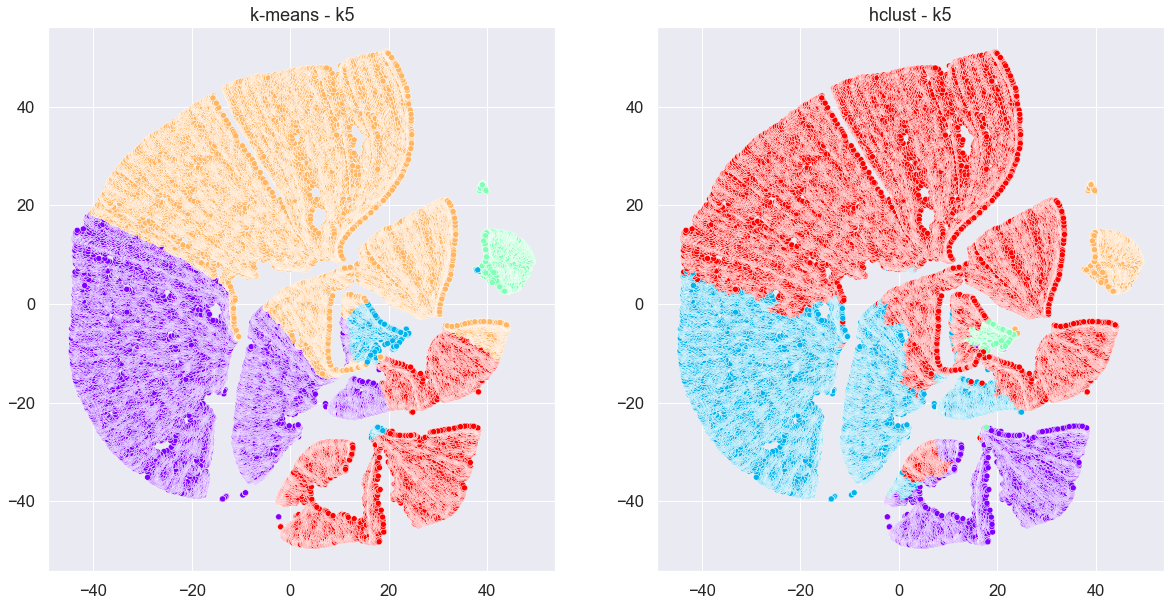

In [122]:
sns.set(rc = {'figure.figsize':(20,10)}, font_scale = 1.5)
fig,ax = plt.subplots(1,2)

# sns.scatterplot(x = X_tsne_100[smpl_, 0], y = X_tsne_100[smpl_, 1], c = model_rfme_k4.predict(X_), cmap = "Set1", ax=ax[0,0]).set(title='k-means - k4');
# sns.scatterplot(x = X_tsne_100[smpl_, 0], y = X_tsne_100[smpl_, 1], c = clustering_rfme_k4.labels_, cmap = "Set1", ax=ax[0,1]).set(title='hclust - k4');

sns.scatterplot(x = X_tsne_200[:,0], y = X_tsne_200[:, 1], c = model_rfme_k5.predict(X_scaled), cmap = "rainbow_r", ax=ax[0]).set(title='k-means - k5');
sns.scatterplot(x = X_tsne_200[:,0], y = X_tsne_200[:, 1], c = preds_5k[3], cmap = "rainbow_r", ax=ax[1]).set(title='hclust - k5');

### DBScan 

#### Find good distance 
##### Heurictic #1

Following heuristic : 

+ $\epsilon$  : calculer pour chaque point de l'espace la distance à son plus proche voisin. Prendre $\epsilon$ tel qu'une part « suffisamment grande » des points aient une distance à son plus proche voisin inférieure à $\epsilon$ ;

+ MinPts : calculer pour chaque point le nombre de ses voisins dans un rayon de taille $\epsilon$ (la taille de son $\epsilon$-voisinage). Prendre MinPts tel qu'une part « suffisamment grande » des points aient plus de MinPts points dans leur $\epsilon$-voisinage.

C:\Users\max\AppData\Local\Temp/ipykernel_19620/1109919388.py:12: RuntimeWarning: divide by zero encountered in log
  p=sns.scatterplot(x = np.array(range(len(distances_)))/len(distances_), y = np.log(distances_), ax = ax[0])


epsilon = 0.04606962634197356
MinPts = 1


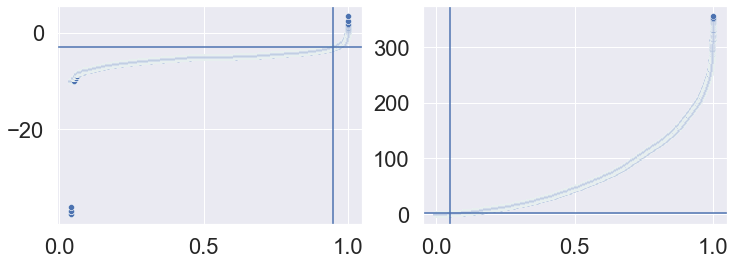

In [131]:
from sklearn.neighbors import NearestNeighbors

sns.set(rc = {'figure.figsize':(12,4)}, font_scale = 2)
fig, ax = plt.subplots(1,2)

threshold = 0.95

# For epsilon
neigh = NearestNeighbors(n_neighbors=1).fit(X_scaled).kneighbors()
distances_ = np.sort(neigh[0].reshape(-1))
epsilon = distances_[int(len(distances_) * threshold)]
p=sns.scatterplot(x = np.array(range(len(distances_)))/len(distances_), y = np.log(distances_), ax = ax[0])
p.axhline(np.log(epsilon))
p.axvline(threshold)

print("epsilon = {}".format(epsilon))

# For minPts
neigh = NearestNeighbors(radius = epsilon).fit(X_scaled).radius_neighbors()
l_v = np.vectorize(len)
n_neighbors_ = np.sort(l_v(neigh[0].reshape(-1)))
minpts = n_neighbors_[int(len(n_neighbors_) * (1-threshold))]

p=sns.scatterplot(x = np.array(range(len(n_neighbors_)))/len(n_neighbors_), y = (n_neighbors_), ax = ax[1])
p.axhline(minpts)
p.axvline(1-threshold)

print("MinPts = {}".format(minpts))

##### DBScan #1

In [144]:
dbscan = cluster.DBSCAN(eps = epsilon, min_samples = 1+minpts).fit(X_subset_scaled) # Min Samples included the point itself (that's why we add 1)
len(Counter(dbscan.labels_))

754

Far to many clusters...

##### Heurictic #2

Une autre heuristique pour les cas en 2D (définie dans l'article original de DBSCAN1) consiste à fixer la valeur de MinPts à 4, et à tracer la courbe (triée dans l'ordre décroissant) des distances de chaque point à leur 4ème plus proche voisin. On fixe alors $\epsilon$ à la valeur du "point seuil" repéré sur le graphe. Si ce seuil n'est pas clairement identifiable, l'utilisateur peut le fixer en estimant le pourcentage de bruit dans le jeu de données : $\epsilon$ est donc tel que seuls les termes de bruit ont une distance à leur 4ème plus proche voisin plus grande que $\epsilon$. 

C:\Users\max\AppData\Local\Temp/ipykernel_19620/2367385826.py:3: RuntimeWarning: divide by zero encountered in log
  sns.scatterplot(x=np.array(range(len(distances_)))/len(distances_), y=np.log(distances_))


<AxesSubplot:>

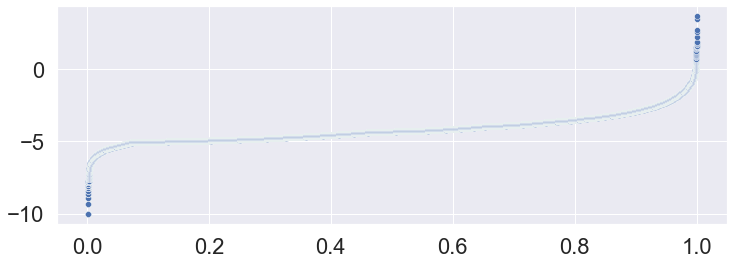

In [126]:
neigh = NearestNeighbors(n_neighbors=4).fit(X_scaled).kneighbors()
distances_ = np.sort(np.apply_along_axis(lambda x : max(x), 1, neigh[0]))
sns.scatterplot(x=np.array(range(len(distances_)))/len(distances_), y=np.log(distances_))

Not clear... Densities are probably not homogeneous in our dataset ! See 3D plot !